# Mapping of registered lightning arroud CG stroke

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import timezone
import datetime as dt
import json
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
#%pylab inline --no-import-all
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import time
os.environ['TZ'] = 'UTC'
time.tzset()
import matplotlib.colors as colors


hdr_t = np.dtype([
    ('magic', 'u4'),
    ('id', 'u4'),
    ('timestamp', 'u4'),
    ('gps_flags', 'u1'),
    ('gps_sat', 'u1'),
    ('gps_lat', 'f4'),
    ('gps_long', 'f4'),
    ('gps_alt', 'u2'),
    ('gps_hour', 'u1'),
    ('gps_min', 'u1'),
    ('gps_sec', 'u1'),
    ('num_energy_data', 'u2'),
], align=True)

energy_data_t = np.dtype([
    ('info', 'u1'),
    ('timestamp_us', 'u4'),
    ('energy', 'f4'),
], align=True)

def read_rt_dat_file(filename):
    ret_dtype = np.dtype([
        ('time', 'u4'),
        ('time_us', 'u4'),
        ('energy', 'f4'),
        ('info', 'u1'),
        ('gps_lat', 'f4'),
        ('gps_long', 'f4'),
        ('gps_alt', 'u2')
    ])
    
    ret = np.zeros(0, dtype=ret_dtype)
    pieces = []

    with open(filename, 'r') as f:
        while True:
            try:
                hdr = np.fromfile(f, dtype=hdr_t, count=1)[0]
            except IndexError:
                break
            if hdr['magic'] != 0xaaaabbbb:
                raise Exception('corrupted data, magic mismatch')
                
            energy_data = np.fromfile(f, dtype=energy_data_t, count=hdr['num_energy_data'])
            piece = np.zeros(len(energy_data), dtype=ret_dtype)
            piece['time'] = hdr['timestamp']
            piece['time_us'] = energy_data['timestamp_us']
            piece['energy'] = energy_data['energy']
            piece['info'] = energy_data['info']
            piece['gps_lat'] = hdr['gps_lat']
            piece['gps_long'] = hdr['gps_long']
            piece['gps_alt'] = hdr['gps_alt']
            pieces.append(piece)
    return np.concatenate(pieces)

In [7]:
# URL
# https://data.blitzortung.org/Data/Protected/

# Tohle stahovani nefunguje

lat=49.5719158
lon=15.9327817
lat=48.7502778
lon=16.3838889
lat=49.5257244
lon=16.5423417
lat=49.14805450000001  
lon=15.148163666666665
lat=50.5550792 # Milesovka
lon=13.9316286

start=pd.Timestamp('2021-07-08 16:14')
end=pd.Timestamp('2021-07-08 16:16')
start=pd.Timestamp('2021-07-14 5:14')
end=pd.Timestamp('2021-07-14 5:15')
start=pd.Timestamp('2021-07-17 14:57')
end=pd.Timestamp('2021-07-17 14:58')
start=pd.Timestamp('2021-07-25 17:54')
end=pd.Timestamp('2021-07-25 18:46')
start=pd.Timestamp('2022-02-04 23:00')
end=pd.Timestamp('2022-02-04 23:50')

# Nespeky
lat=49.8791847
lon=14.6786592
start=pd.Timestamp('2023-01-01 19:00')
end=pd.Timestamp('2023-01-01 19:30')
start=pd.Timestamp('2023-02-25 9:30')
end=pd.Timestamp('2023-02-25 9:45')


print(start, end, lat, lon)
region=1

### url for json data preparation
url=[]

for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html.decode("utf-8"),lines=True)
        #blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
        blitz = pd.concat([blitz,blitz_part])
    except:
        print("No data", url[i])
        pass
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
blitz=blitz[(blitz['lon']>(lon-3.5) )&(blitz['lon']<(lon+3.5) )]

### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees

try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
    pass
#blitz['time']=blitz.index    
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

print('end')

2023-02-25 09:30:00 2023-02-25 09:45:00 49.8791847 14.6786592
end


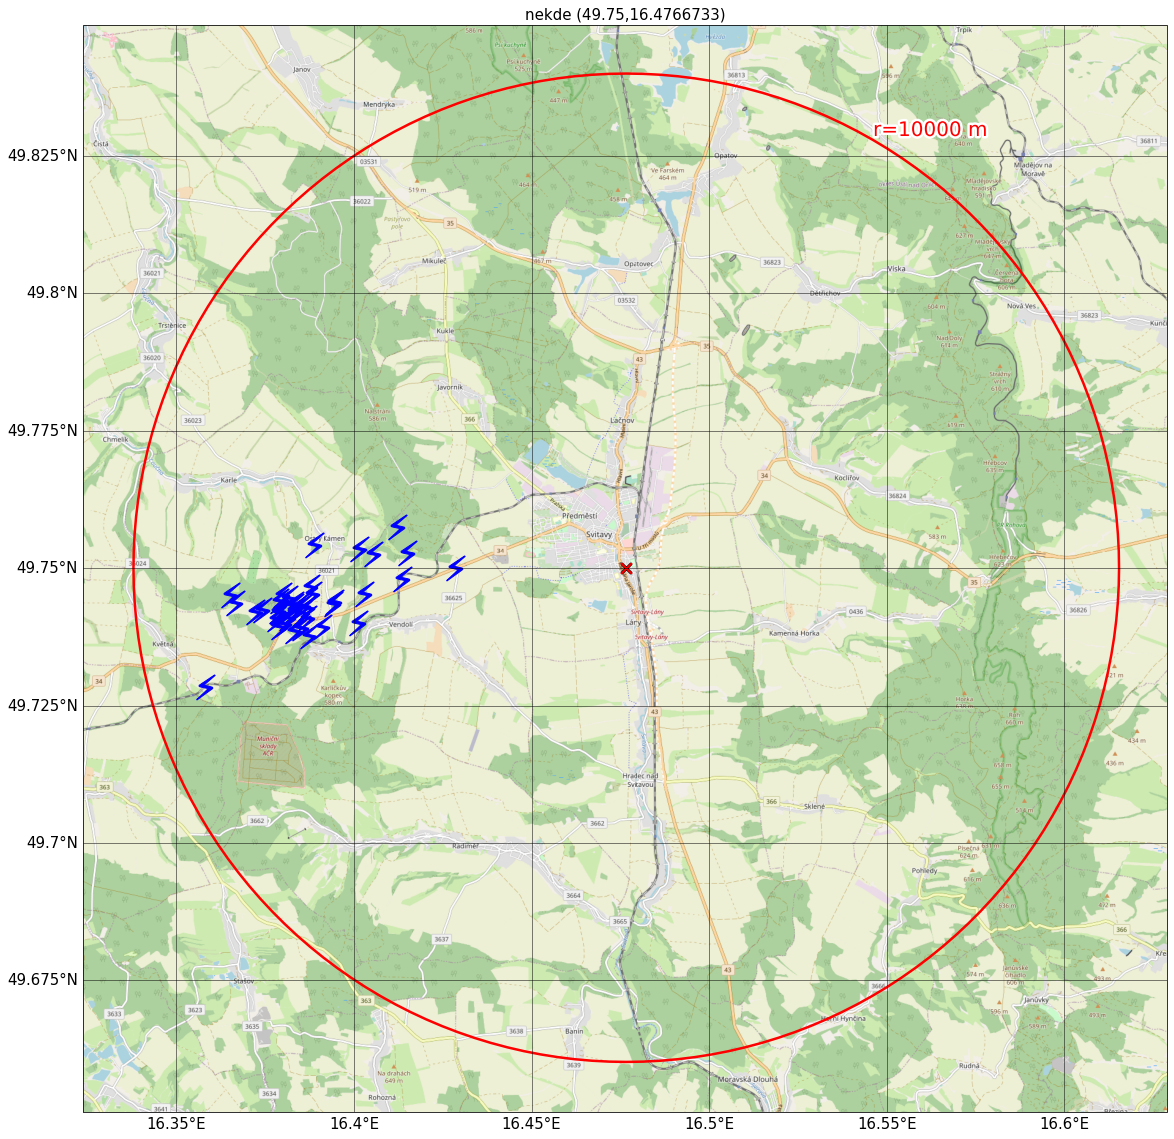

In [27]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

    sitename = 'Polednik'
    lat = 49.063936
    lon = 13.395348
    #lat = 49.5
    #lon = 14.3
    sitename = 'Kosetice'
    lat=49.5722392
    lon=15.0799906
    
    sitename = 'nekde'
    lat=49.75
    lon=16.4766733
    
    RADIUS = 10000
    
    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    osm_image(lon, lat, sitename=sitename, style='map', radius=RADIUS, npoints=0)

    return

##########################################################################

def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500,npoints=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    scale = int(120/np.log(radius))
    scale = (scale<20) and scale or 19

    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    ax.plot(lon,lat, color='red', marker='x', ms=11, mew=2, transform=data_crs)

    if npoints>0: 
        # set random azimuth angles (seed for reproducablity)
        np.random.seed(1235)
        rand_azimuths_deg = np.random.random(npoints)*360

        # set random distances (seed for reproducablity)
        np.random.seed(6341)
        rand_distances = radius*np.sqrt((np.random.random(npoints))) # np.random.uniform(low=0, high=radius, size=npoints)

        rand_lon = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,0]
        rand_lat = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,1]

        ax.plot(rand_lon,rand_lat,color='black',lw=0,marker='x',ms=4.5,mew=1.0,transform=data_crs)
        ax.plot(rand_lon,rand_lat,color='yellow',lw=0,marker='x',ms=4,mew=0.5,transform=data_crs)

    #lightning = blitz.loc['2021-08-15 16:00:00':'2021-08-15 20:00:00']
    lightning = blitz
    #lightning = blitz.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
    #ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u21AF$',ms=25,mew=1.0,transform=data_crs)
    #ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$\u26A1$',ms=35,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u26A1$',ms=25,mew=1.0,transform=data_crs)

    # Cas jednotlivych bodu
    #for index, row in lightning.iterrows():
    #    ax.text(row.lon, row.lat, row.UTC, color='red', fontsize=10, ha='left',va='bottom', transform=data_crs)


    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={radius} m', color='red', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.show()

    #fig.savefig(f'{projpath}/{sitename}_{style}_r{radius}_pts{npoints}_scale{scale}.jpg', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":

   main()

# Old version

In [3]:
raise SystemExit("Old version")
    
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
import matplotlib
import glob
from matplotlib.colors import LogNorm

matplotlib.rcParams.update({'font.size': 15})

plt.figure(figsize=(15,15))
plt.tight_layout()
m = Basemap(lon_0=0, llcrnrlon=lon-0.04,llcrnrlat=lat-0.02,urcrnrlon=lon+0.04,urcrnrlat=lat+0.02,  epsg = 3395,resolution='i',projection='merc')
m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 900, verbose= True)
m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0], color='gray')
m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0], color='gray')

x, y = m(blitz.lon.tolist(),blitz.lat.tolist())
H, xedges, yedges = np.histogram2d(x,y)
im1 = m.scatter(x,y, marker='.', s = 100, alpha=1, color='red')

x, y = m([lon],[lat])
im1 = m.scatter(x,y,marker='+', s = 500, color='red')

m.drawmapscale(lon-0.03, lat-0.017 ,lon, lat, 2, barstyle='fancy')

plt.show() 


SystemExit: Old version

In [4]:
raise SystemExit("Old version")

import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
import matplotlib
import glob
from matplotlib.colors import LogNorm

matplotlib.rcParams.update({'font.size': 15})

plt.figure(figsize=(15,15))
plt.tight_layout()
m = Basemap(lon_0=0, llcrnrlon=lon-0.08,llcrnrlat=lat-0.04,urcrnrlon=lon+0.08,urcrnrlat=lat+0.04,  epsg = 3395,resolution='i',projection='merc')
m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 900, verbose= True)
m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0], color='gray')
m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0], color='gray')

x, y = m(blitz.lon.tolist(),blitz.lat.tolist())
H, xedges, yedges = np.histogram2d(x,y)
im1 = m.scatter(x,y, marker='.', s = 100, alpha=1, color='red')

x, y = m([lon],[lat])
im1 = m.scatter(x,y,marker='+', s = 500, color='red')

m.drawmapscale(lon, lat-0.03 ,lon, lat, 2, barstyle='fancy')

plt.show() 


SystemExit: Old version

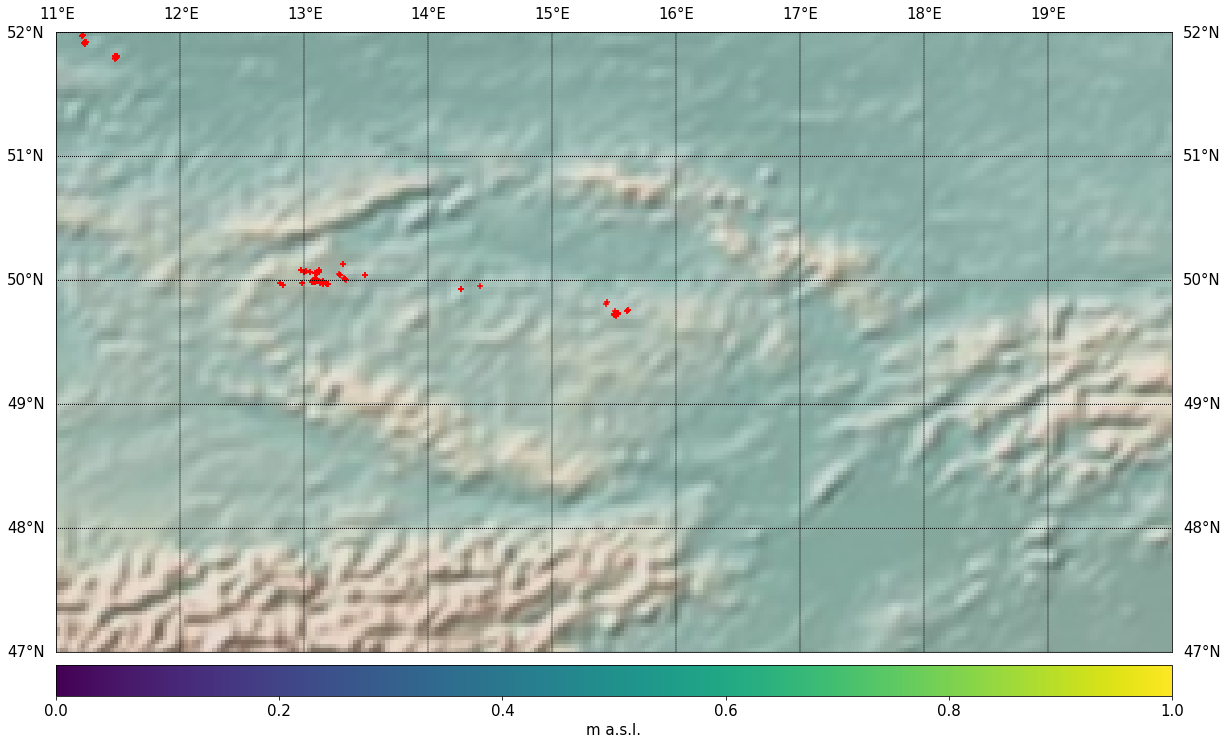

In [39]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os

plt.figure(figsize=(20,20))
plt.tight_layout()

matplotlib.rcParams.update({'font.size': 15})

# create Basemap instance.
#m = Basemap(projection='kav7',lon_0=0)
m = Basemap(projection='cyl',lon_0=0, llcrnrlon=11,llcrnrlat=47,urcrnrlon=20,urcrnrlat=52)
#m = Basemap(projection='robin',lon_0=0)
#m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

x, y = m(blitz.lon.tolist(),blitz.lat.tolist())
#m.drawmapboundary(fill_color='#99ffff')
#m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0])
m.shadedrelief()

im1 = m.scatter(x,y,marker='+', color='red' )
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')

#plt.clim(0, 12500)  # limit for color axis
plt.show()                


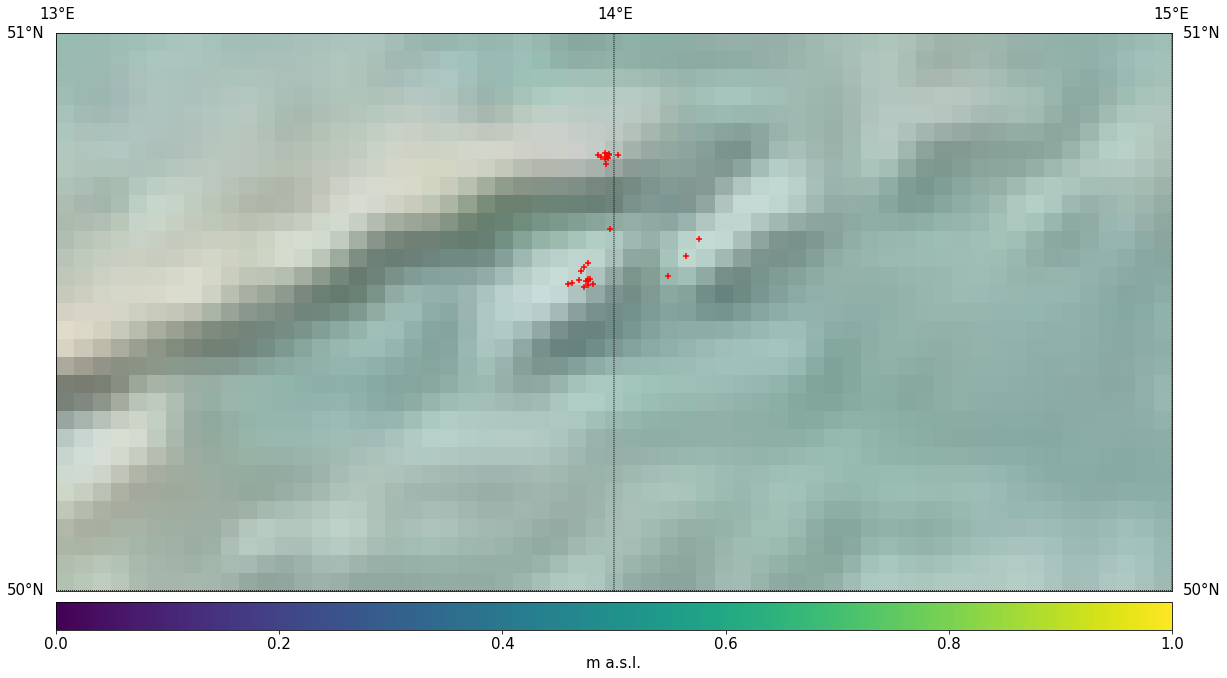

In [14]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os

plt.figure(figsize=(20,20))
plt.tight_layout()

matplotlib.rcParams.update({'font.size': 15})

# create Basemap instance.
#m = Basemap(projection='kav7',lon_0=0)
m = Basemap(projection='cyl',lon_0=0, llcrnrlon=13,llcrnrlat=50,urcrnrlon=15,urcrnrlat=51)
#m = Basemap(projection='robin',lon_0=0)
#m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

x, y = m(blitz.lon.tolist(),blitz.lat.tolist())
#m.drawmapboundary(fill_color='#99ffff')
#m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0])
m.shadedrelief()

im1 = m.scatter(x,y,marker='+', color='red' )
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')

#plt.clim(0, 12500)  # limit for color axis
plt.show()                


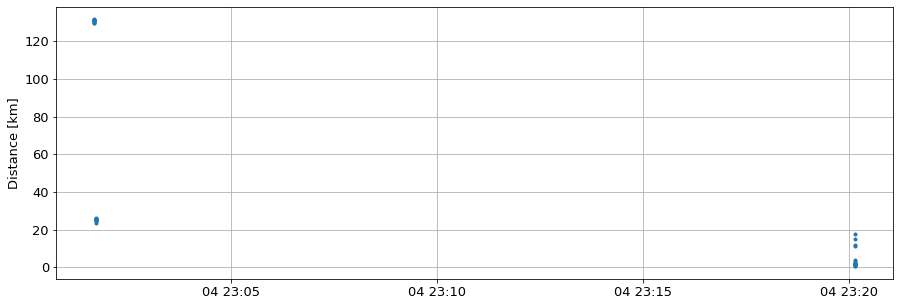

In [18]:
blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.

#blitz = pd.read_csv(directory + "/blitz.csv")
#blitz['date'] = pd.to_datetime(blitz['date'])
#blitz.set_index('date', inplace=True)
#blitz.sort_index(inplace=True)

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 13})

blitz['date'] = pd.to_datetime(blitz.index, unit='ns')

plt.plot(blitz['date'], blitz['km'], ls='', marker='.')
#plt.ylim([0,40])
plt.ylabel('Distance [km]')
plt.grid()

In [21]:
directory = '/storage/experiments/2023/0201_vanice/blitzortung/'
directory = '/storage/experiments/2023/0225_vanice/blitzortung/'

import requests
blitz=pd.DataFrame()
for region in ('1','18','19'):#,'1.1','18.1'):
    #f = open(directory+region+'/'+'00'+'.json')  
    #html = f.read()
    #blitz_part = pd.read_json(html,lines=True)
    #blitz = pd.concat([blitz,blitz_part])
    for i in ('40','50'): #range(10,60,10):
        try:
            f = open(directory+region+'/'+i+'.json')  
            print(f)
            html = f.read()
            blitz_part = pd.read_json(html,lines=True)
            blitz = pd.concat([blitz,blitz_part])
        except:
            pass

blitz.set_index(['time'], inplace=True)

### reduction of too distant events
#blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
#blitz=blitz[(blitz['lon']>(lon-3.5) )&(blitz['lon']<(lon+3.5) )]

### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees

try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
    pass
#blitz['time']=blitz.index    
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

print('end')

<_io.TextIOWrapper name='/storage/experiments/2023/0225_vanice/blitzortung/1/40.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/storage/experiments/2023/0225_vanice/blitzortung/1/50.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/storage/experiments/2023/0225_vanice/blitzortung/18/40.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/storage/experiments/2023/0225_vanice/blitzortung/18/50.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/storage/experiments/2023/0225_vanice/blitzortung/19/40.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/storage/experiments/2023/0225_vanice/blitzortung/19/50.json' mode='r' encoding='UTF-8'>
end


In [19]:
blitz

time        lat        lon  \
date                                                                       
2023-02-25 09:40:05.564059271  1677318005564059271  38.852258 -49.028240   
2023-02-25 09:40:51.211655477  1677318051211655477  41.355457 -45.152439   
2023-02-25 09:41:00.153806479  1677318060153806479  39.558354   5.066076   
2023-02-25 09:41:00.153827609  1677318060153827609  39.516978   5.007584   
2023-02-25 09:41:22.225512582  1677318082225512582  45.939314  21.201578   
...                                            ...        ...        ...   
2023-02-25 09:48:03.374891697  1677318483374891697  34.983998  11.516045   
2023-02-25 09:48:03.374881314  1677318483374881314  34.942478  11.498700   
2023-02-25 09:48:22.170911716  1677318502170911716  44.124104  36.990726   
2023-02-25 09:48:48.612571965  1677318528612571965  35.401831  11.265026   
2023-02-25 09:49:40.798301908  1677318580798301908  39.545595   4.997443   

                                 mds  mcg  status  \
date                                                
2023-02-25 09:40:05.564059271   8087  169       0   
2023-02-25 09:40:51.211655477   9619  158       0   
2023-02-25 09:41:00.153806479   5451  221       0   
2023-02-25 09:41:00.153827609   9833  195       0   
2023-02-25 09:41:22.225512582  13320  134       0   
...                              ...  ...     ...   
2023-02-25 09:48:03.374891697   9345  252       1   
2023-02-25 09:48:03.374881314   5447  261       1   
2023-02-25 09:48:22.170911716   9880  203       1   
2023-02-25 09:48:48.612571965   7378  251       1   
2023-02-25 09:49:40.798301908   7562  270       1   

                                                                             sig  
date                                                                              
2023-02-25 09:40:05.564059271  [{'sta': 2811, 'time': 5763604, 'lat': 38.4851...  
2023-02-25 09:40:51.211655477  [{'sta': 2811, 'time': 4746344, 'lat': 38.4851...  
2023-02-25 09:41:00.153806479  [{'sta': 2324, 'time': 1372493, 'lat': 42.3734...  
2023-02-25 09:41:00.153827609  [{'sta': 2788, 'time': 2410171, 'lat': 43.4320...  
2023-02-25 09:41:22.225512582  [{'sta': 2549, 'time': 354432, 'lat': 46.86736...  
...                                                                          ...  
2023-02-25 09:48:03.374891697  [{'sta': 1443, 'time': 3286678, 'lat': 43.9600...  
2023-02-25 09:48:03.374881314  [{'sta': 2818, 'time': 3831020, 'lat': 45.4478...  
2023-02-25 09:48:22.170911716  [{'sta': 2484, 'time': 2558067, 'lat': 46.2393...  
2023-02-25 09:48:48.612571965  [{'sta': 1583, 'time': 1949505, 'lat': 38.9523...  
2023-02-25 09:49:40.798301908  [{'sta': 2888, 'time': 1096912, 'lat': 36.7593...  

[118 rows x 7 columns]

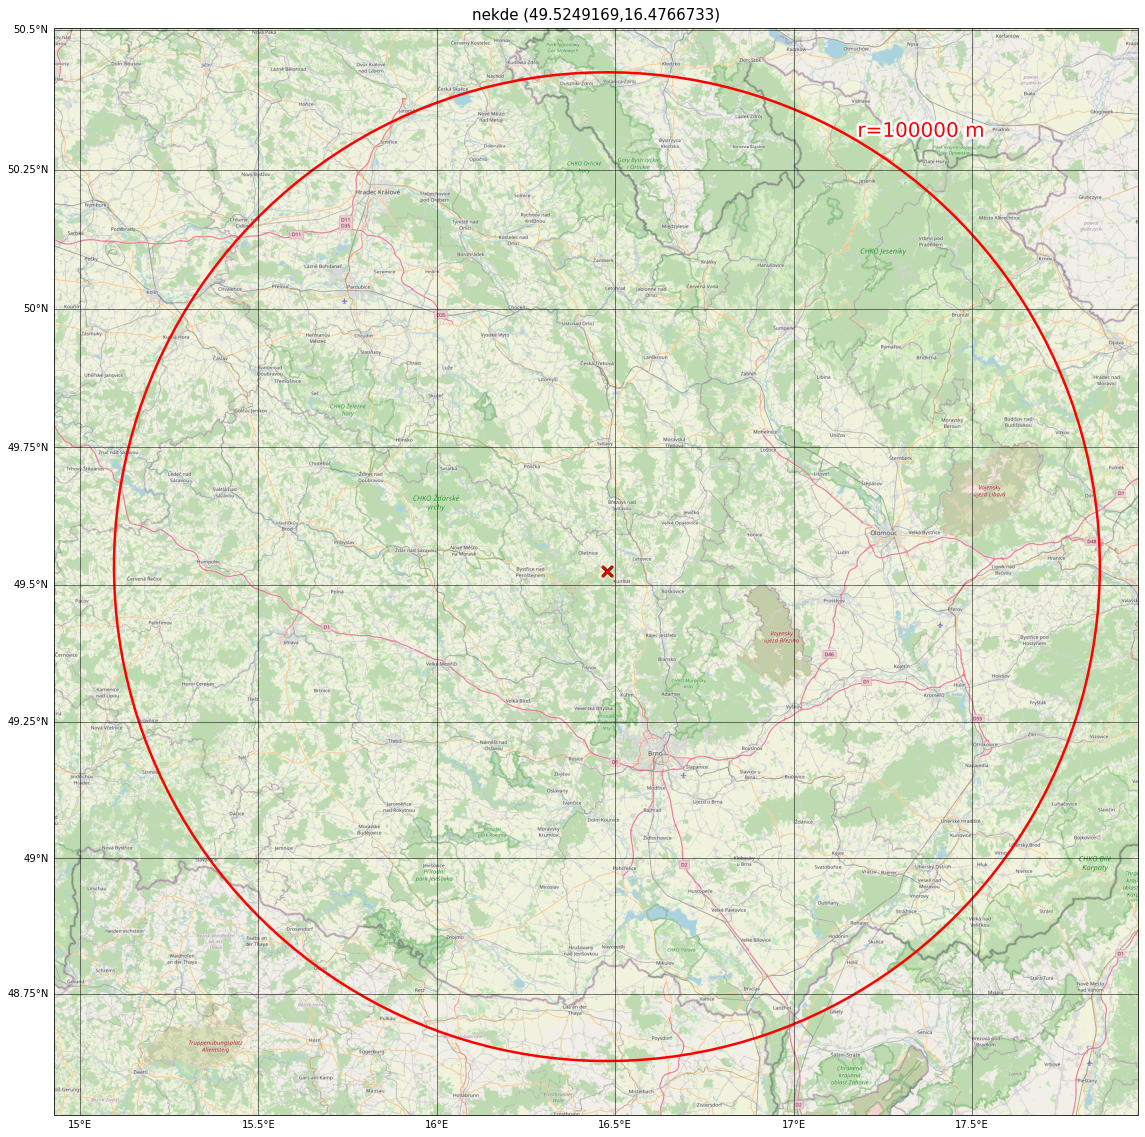

In [23]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

    sitename = 'Polednik'
    lat = 49.063936
    lon = 13.395348
    #lat = 49.5
    #lon = 14.3
    sitename = 'Kosetice'
    lat=49.5722392
    lon=15.0799906
    
    sitename = 'nekde'
    lat=49.5249169
    lon=16.4766733
    
    RADIUS = 100000
    
    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    osm_image(lon, lat, sitename=sitename, style='map', radius=RADIUS, npoints=0)

    return

##########################################################################

def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500,npoints=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    scale = int(120/np.log(radius))
    scale = (scale<20) and scale or 19

    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    ax.plot(lon,lat, color='red', marker='x', ms=11, mew=2, transform=data_crs)

    if npoints>0: 
        # set random azimuth angles (seed for reproducablity)
        np.random.seed(1235)
        rand_azimuths_deg = np.random.random(npoints)*360

        # set random distances (seed for reproducablity)
        np.random.seed(6341)
        rand_distances = radius*np.sqrt((np.random.random(npoints))) # np.random.uniform(low=0, high=radius, size=npoints)

        rand_lon = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,0]
        rand_lat = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,1]

        ax.plot(rand_lon,rand_lat,color='black',lw=0,marker='x',ms=4.5,mew=1.0,transform=data_crs)
        ax.plot(rand_lon,rand_lat,color='yellow',lw=0,marker='x',ms=4,mew=0.5,transform=data_crs)

    #lightning = blitz.loc['2021-08-15 16:00:00':'2021-08-15 20:00:00']
    lightning = blitz
    #lightning = blitz.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
    ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$🗲$',ms=15,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$🗲$',ms=10,mew=1.0,transform=data_crs)

    # Cas jednotlivych bodu
    #for index, row in lightning.iterrows():
    #    ax.text(row.lon, row.lat, row.UTC, color='red', fontsize=10, ha='left',va='bottom', transform=data_crs)


    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={radius} m', color='red', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.show()

    #fig.savefig(f'{projpath}/{sitename}_{style}_r{radius}_pts{npoints}_scale{scale}.jpg', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":

   main()

In [53]:
#blitz.to_csv('zimni_bourka.csv')
blitz


time        lat        lon  \
date                                                                       
2023-02-01 19:00:00.349759458  1675278000349759458  51.326862   7.590839   
2023-02-01 19:00:00.349759458  1675278000349759458  51.326862   7.590839   
2023-02-01 19:00:00.367517650  1675278000367517650  51.306866   7.688167   
2023-02-01 19:00:00.367517650  1675278000367517650  51.306866   7.688167   
2023-02-01 19:00:00.376698162  1675278000376698162  51.333960   7.644546   
...                                            ...        ...        ...   
2023-02-01 20:59:16.807033717  1675285156807033717  30.481697  51.671325   
2023-02-01 20:59:44.066907844  1675285184066907844  49.102057  16.131634   
2023-02-01 20:59:44.066907902  1675285184066907902  49.086493  16.132941   
2023-02-01 20:59:44.066912859  1675285184066912859  49.099680  16.138143   
2023-02-01 20:59:44.127059305  1675285184127059305  49.097612  16.137480   

                                 mds  mcg  status  \
date                                                
2023-02-01 19:00:00.349759458   6424  148       1   
2023-02-01 19:00:00.349759458   6424  148       2   
2023-02-01 19:00:00.367517650   8165  157       2   
2023-02-01 19:00:00.367517650   8165  157       1   
2023-02-01 19:00:00.376698162  13690   59       1   
...                              ...  ...     ...   
2023-02-01 20:59:16.807033717  10850  242       0   
2023-02-01 20:59:44.066907844   6227  112       1   
2023-02-01 20:59:44.066907902   8057   71       1   
2023-02-01 20:59:44.066912859   6986   74       1   
2023-02-01 20:59:44.127059305   8819   45       1   

                                                                             sig  
date                                                                              
2023-02-01 19:00:00.349759458  [{'sta': 2957, 'time': 176145, 'lat': 50.90777...  
2023-02-01 19:00:00.349759458  [{'sta': 2957, 'time': 176145, 'lat': 50.90777...  
2023-02-01 19:00:00.367517650  [{'sta': 2957, 'time': 181788, 'lat': 50.90777...  
2023-02-01 19:00:00.367517650  [{'sta': 2957, 'time': 181788, 'lat': 50.90777...  
2023-02-01 19:00:00.376698162  [{'sta': 2957, 'time': 184604, 'lat': 50.90777...  
...                                                                          ...  
2023-02-01 20:59:16.807033717  [{'sta': 2640, 'time': 2396539, 'lat': 24.1763...  
2023-02-01 20:59:44.066907844  [{'sta': 1035, 'time': 999581, 'lat': 48.55387...  
2023-02-01 20:59:44.066907902  [{'sta': 2116, 'time': 266302, 'lat': 48.37986...  
2023-02-01 20:59:44.066912859  [{'sta': 2902, 'time': 1539258, 'lat': 46.2971...  
2023-02-01 20:59:44.127059305  [{'sta': 2116, 'time': 270173, 'lat': 48.37986...  

[1589 rows x 7 columns]

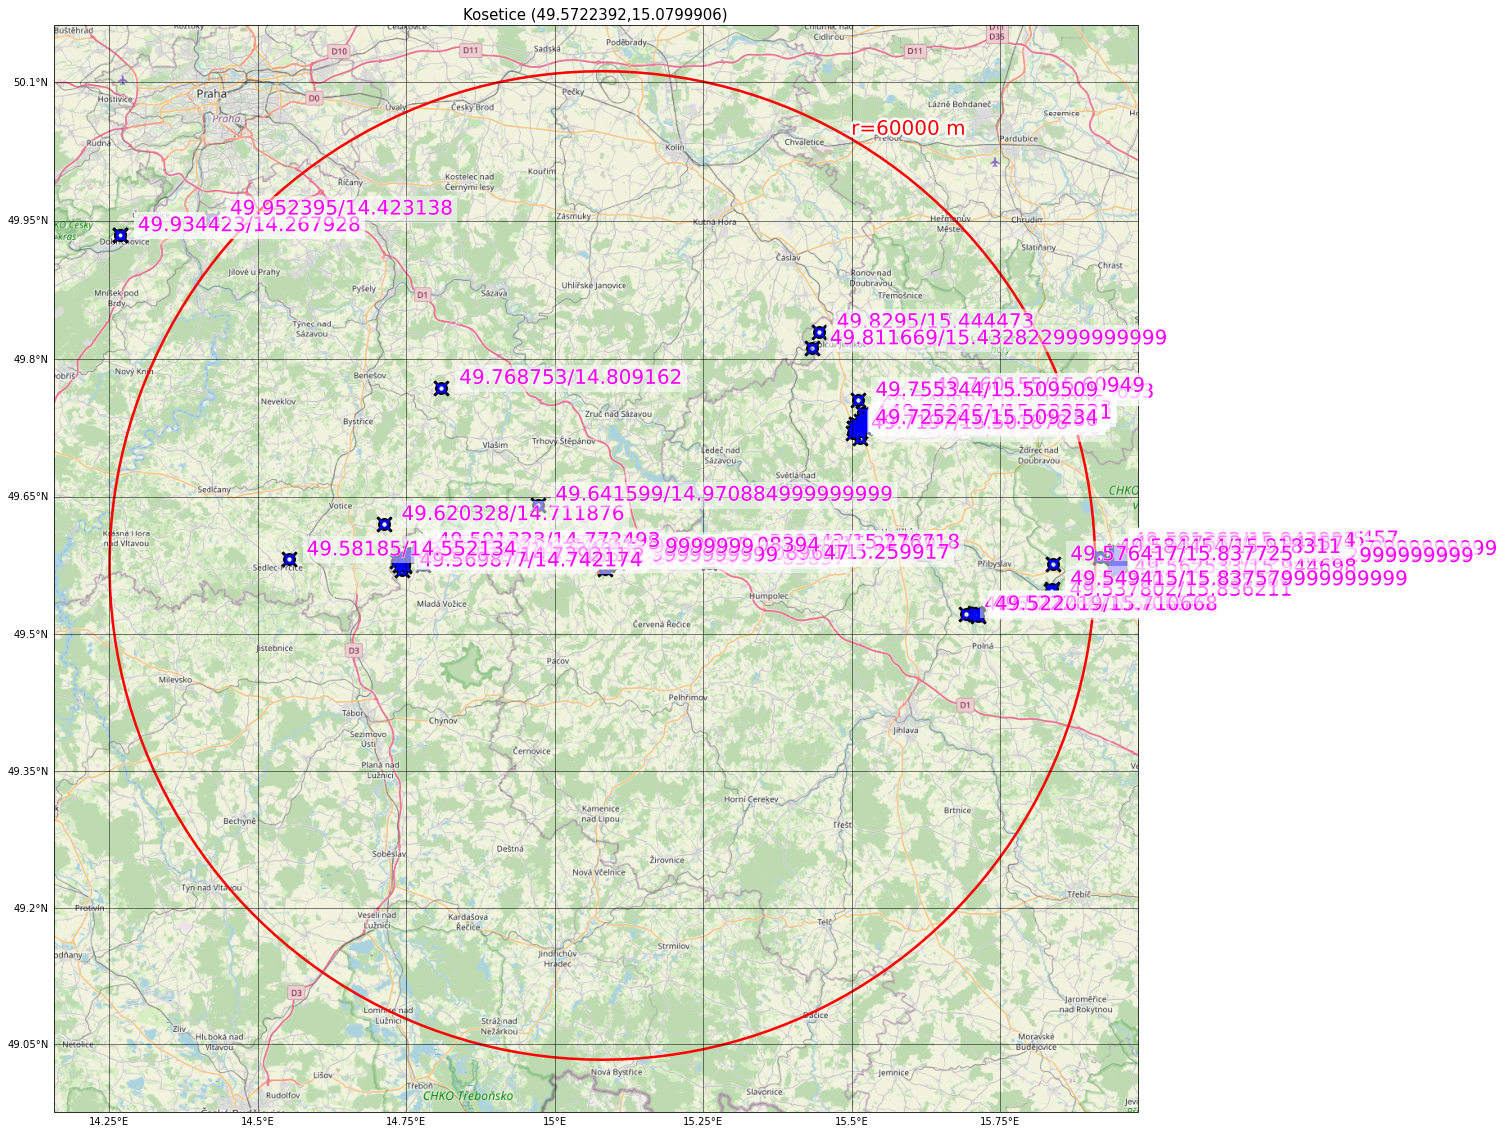

                                              time        lat        lon  \
date                                                                       
2023-02-01 19:39:54.156254398  1675280394156254398  49.724923  15.506259   
2023-02-01 19:39:54.156254412  1675280394156254412  49.723899  15.506989   
2023-02-01 19:39:54.156255029  1675280394156255029  49.722186  15.508970   
2023-02-01 19:39:54.156255029  1675280394156255029  49.722186  15.508970   
2023-02-01 19:39:54.156255323  1675280394156255323  49.725564  15.518658   
2023-02-01 19:39:54.156256959  1675280394156256959  49.727929  15.522211   
2023-02-01 19:39:54.156257704  1675280394156257704  49.728001  15.522037   
2023-02-01 19:39:54.156257704  1675280394156257704  49.728001  15.522037   
2023-02-01 19:39:54.156257961  1675280394156257961  49.724920  15.506257   
2023-02-01 19:39:54.156257961  1675280394156257961  49.724920  15.506257   
2023-02-01 19:39:54.156258239  1675280394156258239  49.734275  15.533111   
2023-02-01 1

In [51]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'


def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500,npoints=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    scale = int(120/np.log(radius))
    scale = (scale<20) and scale or 19

    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    ax.plot(lon,lat, color='red', marker='x', ms=11, mew=2, transform=data_crs)

    #lightning = blitz.loc['2021-08-15 16:00:00':'2021-08-15 20:00:00']
    #lightning = blitz
    
    blitz.sort_index(inplace=True)
    lightning = blitz.loc['2023-02-01 19:00:00':'2023-02-01 20:10:00']
    lightning = lightning.loc[lightning.lat< (lat+1)]
    lightning = lightning.loc[lightning.lat> (lat-1)]
    lightning = lightning.loc[lightning.lon< (lon+1)]
    lightning = lightning.loc[lightning.lon> (lon-1)]

    ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$🗲$',ms=15,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$🗲$',ms=10,mew=1.0,transform=data_crs)
    for index, row in lightning.iterrows():
        t = ax.text(row.lon+0.03, row.lat, str(row.lat) + '/' + str(row.lon), color='magenta', fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)
        t.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    
    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={radius} m', color='red', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.show()

    #fig.savefig(f'{projpath}/{sitename}_{style}_r{radius}_pts{npoints}_scale{scale}.jpg', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

sitename = 'Polednik'
lat = 49.063936
lon = 13.395348
#lat = 49.5
#lon = 14.3
lat=49.8604864 
lon=14.6501794
sitename = 'Kosetice'
lat=49.5722392
lon=15.0799906



# style can be 'map' or 'satellite'

#for style in ['map','satellite']:

osm_image(lon, lat, sitename=sitename, style='map', radius=60000, npoints=0)

print(lightning)


In [42]:
blitz.sort_index(inplace=True)
lightning = blitz.loc['2023-02-01 19:10:00':'2023-02-01 19:55:00']
lightning = lightning.loc[lightning.lat< (lat+0.2)]
lightning = lightning.loc[lightning.lat> (lat-0.2)]
lightning = lightning.loc[lightning.lon< (lon+0.5)]
lightning = lightning.loc[lightning.lon> (lon-0.5)]
lightning

time        lat        lon  \
date                                                                       
2023-02-01 19:39:54.156254398  1675280394156254398  49.724923  15.506259   
2023-02-01 19:39:54.156254412  1675280394156254412  49.723899  15.506989   
2023-02-01 19:39:54.156255029  1675280394156255029  49.722186  15.508970   
2023-02-01 19:39:54.156255029  1675280394156255029  49.722186  15.508970   
2023-02-01 19:39:54.156255323  1675280394156255323  49.725564  15.518658   
2023-02-01 19:39:54.156256959  1675280394156256959  49.727929  15.522211   
2023-02-01 19:39:54.156257704  1675280394156257704  49.728001  15.522037   
2023-02-01 19:39:54.156257704  1675280394156257704  49.728001  15.522037   
2023-02-01 19:39:54.156257961  1675280394156257961  49.724920  15.506257   
2023-02-01 19:39:54.156257961  1675280394156257961  49.724920  15.506257   
2023-02-01 19:39:54.156258239  1675280394156258239  49.734275  15.533111   
2023-02-01 19:39:54.156258239  1675280394156258239  49.734275  15.533111   
2023-02-01 19:39:54.156260777  1675280394156260777  49.725198  15.521523   
2023-02-01 19:39:54.156260963  1675280394156260963  49.723244  15.510038   
2023-02-01 19:39:54.156263516  1675280394156263516  49.736900  15.521601   
2023-02-01 19:39:54.156263615  1675280394156263615  49.727906  15.510079   
2023-02-01 19:39:54.156263615  1675280394156263615  49.727906  15.510079   
2023-02-01 19:39:54.156327070  1675280394156327070  49.737899  15.528363   
2023-02-01 19:39:54.156340406  1675280394156340406  49.713873  15.514496   
2023-02-01 19:39:54.182314418  1675280394182314418  49.732105  15.514645   
2023-02-01 19:39:54.182315003  1675280394182315003  49.728058  15.510656   
2023-02-01 19:39:54.182315377  1675280394182315377  49.721567  15.513053   
2023-02-01 19:39:54.182315377  1675280394182315377  49.721567  15.513053   
2023-02-01 19:39:54.182319765  1675280394182319765  49.740881  15.519006   
2023-02-01 19:39:54.182319765  1675280394182319765  49.740881  15.519006   
2023-02-01 19:39:54.182319896  1675280394182319896  49.735068  15.532983   
2023-02-01 19:39:54.182320752  1675280394182320752  49.725545  15.504079   
2023-02-01 19:39:54.182320752  1675280394182320752  49.725545  15.504079   
2023-02-01 19:39:54.182322793  1675280394182322793  49.728695  15.527690   
2023-02-01 19:39:54.182325146  1675280394182325146  49.728955  15.507043   
2023-02-01 19:39:54.182325404  1675280394182325404  49.730881  15.532521   
2023-02-01 19:39:54.182325404  1675280394182325404  49.730881  15.532521   
2023-02-01 19:39:54.182384015  1675280394182384015  49.723095  15.509286   
2023-02-01 19:39:54.182392937  1675280394182392937  49.755344  15.509509   
2023-02-01 19:39:54.182394469  1675280394182394469  49.719700  15.501878   
2023-02-01 19:39:54.197244845  1675280394197244845  49.725245  15.509234   

                                 mds  mcg  status  \
date                                                
2023-02-01 19:39:54.156254398   8319   79       0   
2023-02-01 19:39:54.156254412  10330   70       0   
2023-02-01 19:39:54.156255029   6381   82       2   
2023-02-01 19:39:54.156255029   6381   82       1   
2023-02-01 19:39:54.156255323  10168  152       0   
2023-02-01 19:39:54.156256959   9678  113       0   
2023-02-01 19:39:54.156257704   9339  116       2   
2023-02-01 19:39:54.156257704   9339  116       1   
2023-02-01 19:39:54.156257961   8320   79       2   
2023-02-01 19:39:54.156257961   8320   79       1   
2023-02-01 19:39:54.156258239   7724  168       2   
2023-02-01 19:39:54.156258239   7724  168       1   
2023-02-01 19:39:54.156260777   4740  203       0   
2023-02-01 19:39:54.156260963   6925  128       0   
2023-02-01 19:39:54.156263516   9927  229       0   
2023-02-01 19:39:54.156263615   4651  113       2   
2023-02-01 19:39:54.156263615   4651  113       1   
2023-02-01 19:39:54.156327070  14563  110       0   
2023-02-01 19:39:54.156340406  13263  101       0   
2023-02-01 19:39:54.182314418   4870  187   